# notebook 2 - celltype annotation and beyond

This notebook will introduce you to the process of celltype annotation and give you a brief outlook of some of the analysis you can do with single-cell data in scanpy & besca.


Initial visualization and hand annotation is performed here to show the possible hand-annotation and how Besca is now proposing an automated annotation process, including for mix-cluster. 
This procedure is done in a more straighforward manner on the same dataset in the notebook available there:

https://github.com/bedapub/besca_publication_results/blob/master/hematopoietic/pbmc3k/celltype_annotation_besca_Rc.ipynb


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#import necessary python packages
import scanpy.api as sc #software suite of tools for single-cell analysis in python
import besca as bc #internal BEDA package for single cell analysis
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy

sc.logging.print_versions() #output an overview of the software versions that are loaded

scanpy==1.5.1 anndata==0.7.3 umap==0.4.3 numpy==1.17.5 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.0


In [4]:
from IPython.display import HTML
task = "<style>div.task { background-color: #ffc299; border-color: #ff944d; border-left: 7px solid #ff944d; padding: 1em;} </style>"
HTML(task)

In [5]:
tag = "<style>div.tag { background-color: #99ccff; border-color: #1a8cff; border-left: 7px solid #1a8cff; padding: 1em;} </style>"
HTML(tag)

In [6]:
FAIR = "<style>div.fair { background-color: #d2f7ec; border-color: #d2f7ec; border-left: 7px solid #2fbc94; padding: 1em;} </style>"
HTML(FAIR)

## Dataset

Here we will reload our previously completely processed dataset.

In [7]:
#adata = sc.read('/tmp/adata_pbmc_FRESH_processed.h5ad')
adata = bc.datasets.pbmc3k_filtered()



In [8]:
adata

AnnData object with n_obs × n_vars = 2504 × 1719
    obs: 'CELL', 'percent_mito', 'experiment', 'n_counts', 'n_genes', 'leiden'
    var: 'ENSEMBL', 'SYMBOL', 'n_cells', 'total_counts', 'frac_reads'
    uns: 'experiment_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Celltype annotation

### manual cell annotation based on the expression of known marker genes

In [9]:
#define genes (in future you will be able to access genesets from a central database GEMS)
b_cells = ['CD19', 'CD79A', 'MS4A1']
t_cells = ['CD3E', 'CD3G', 'CD3D']
t_cell_subsets = ['CD4', 'CD8A', 'CD8B']
naive_t_cell = ['SELL', 'CCR7', 'IL7R']
myeloid_cells = ['S100A8', 'S100A9', 'CST3']
monocytes = ['FCGR3A', 'FCGR3B', 'CD14'] #FCGR3A/B = CD16
dendritic_cells = ['FCER1A', 'ITGAM', 'ITGAX'] #ITGAM = CD11b #ITGAX= CD11c 
NK_cells = ['NCAM1', 'NKG7', 'CD3G']

<div class="tag">
We always use the HGNC symbols of genes as the main annotation type in the AnnData object since they are the most practical to work with. In addition, the ensemble IDs of all genes is saved in adata.var according to our FAIR standard and always written out since Ensembl IDs stay very robust over time.

Based on the dataset the marker genes that are expressed may vary strongly.
    
</div>

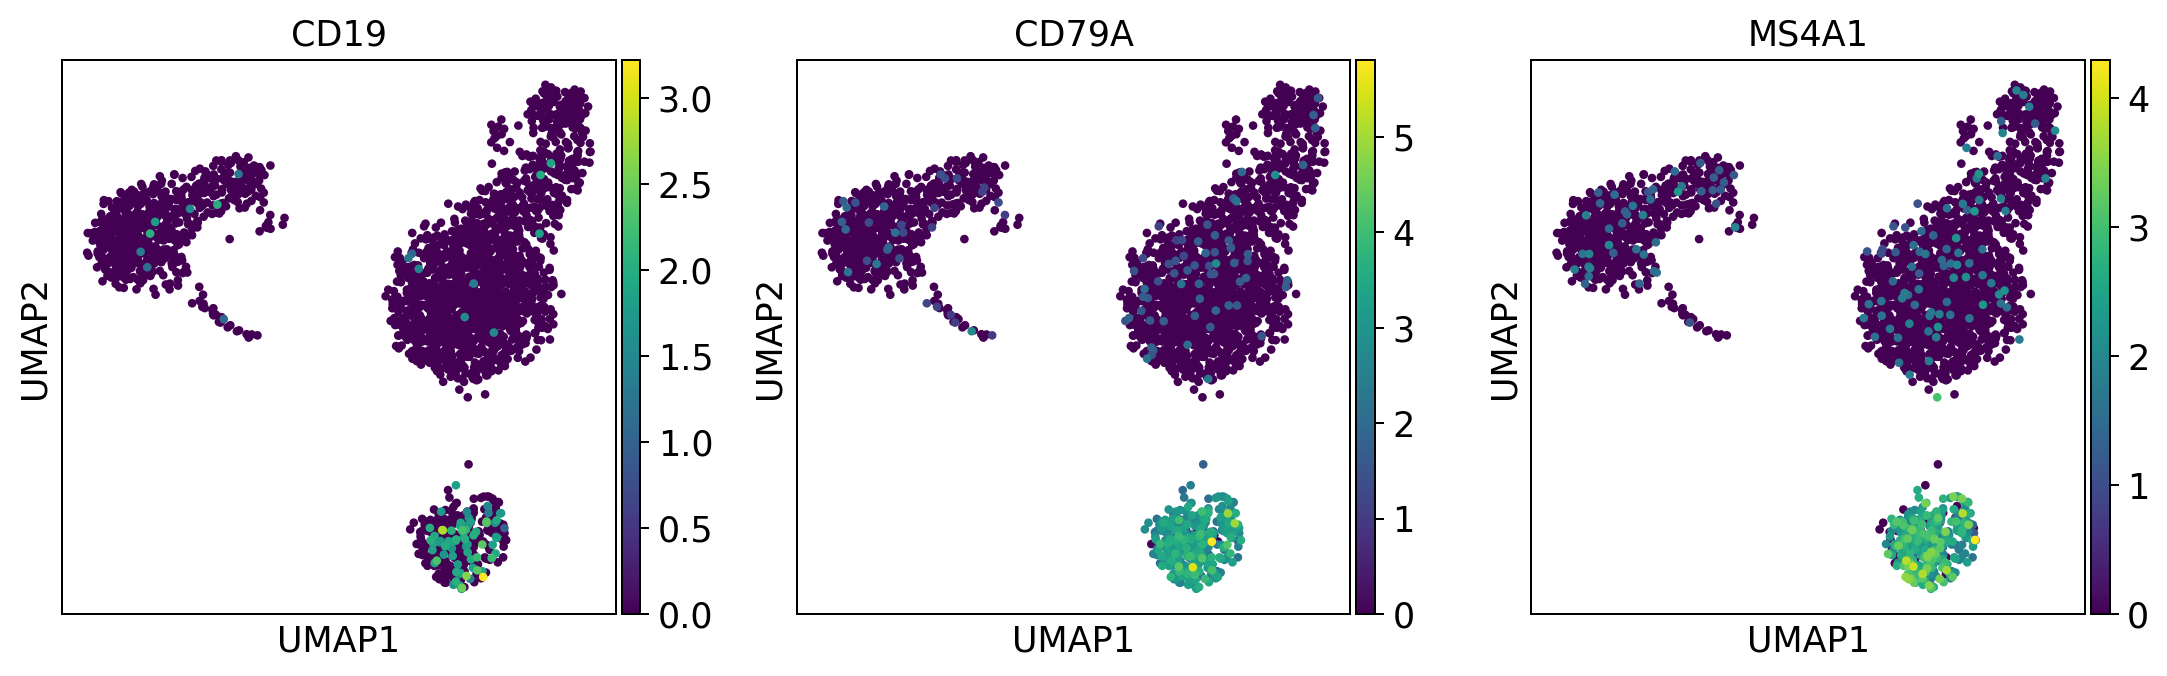

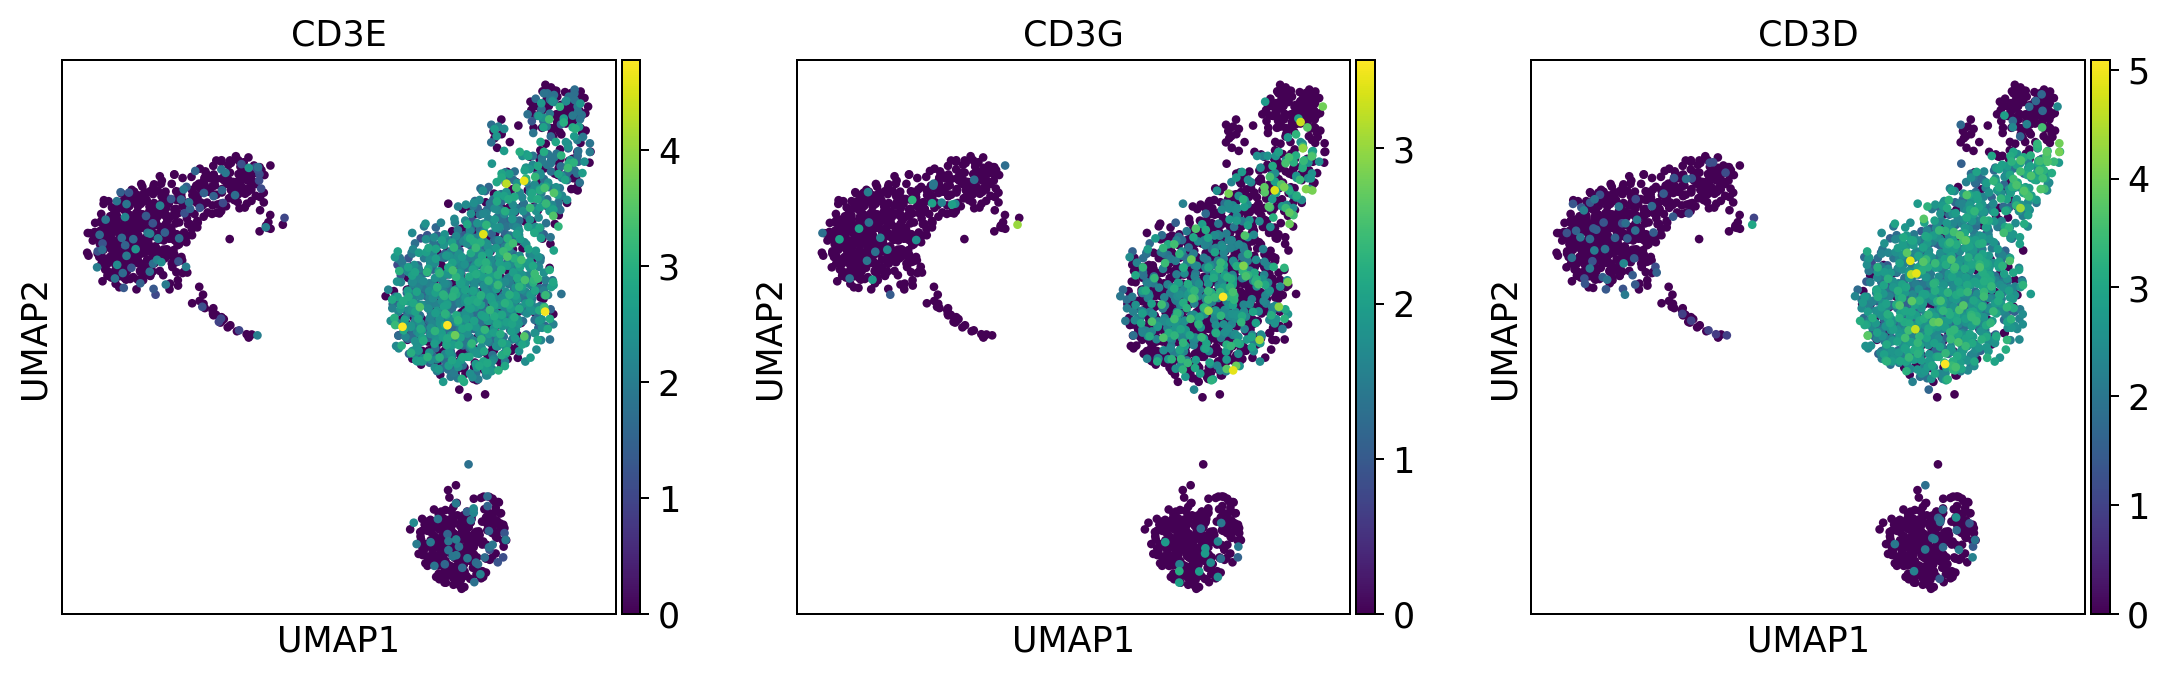

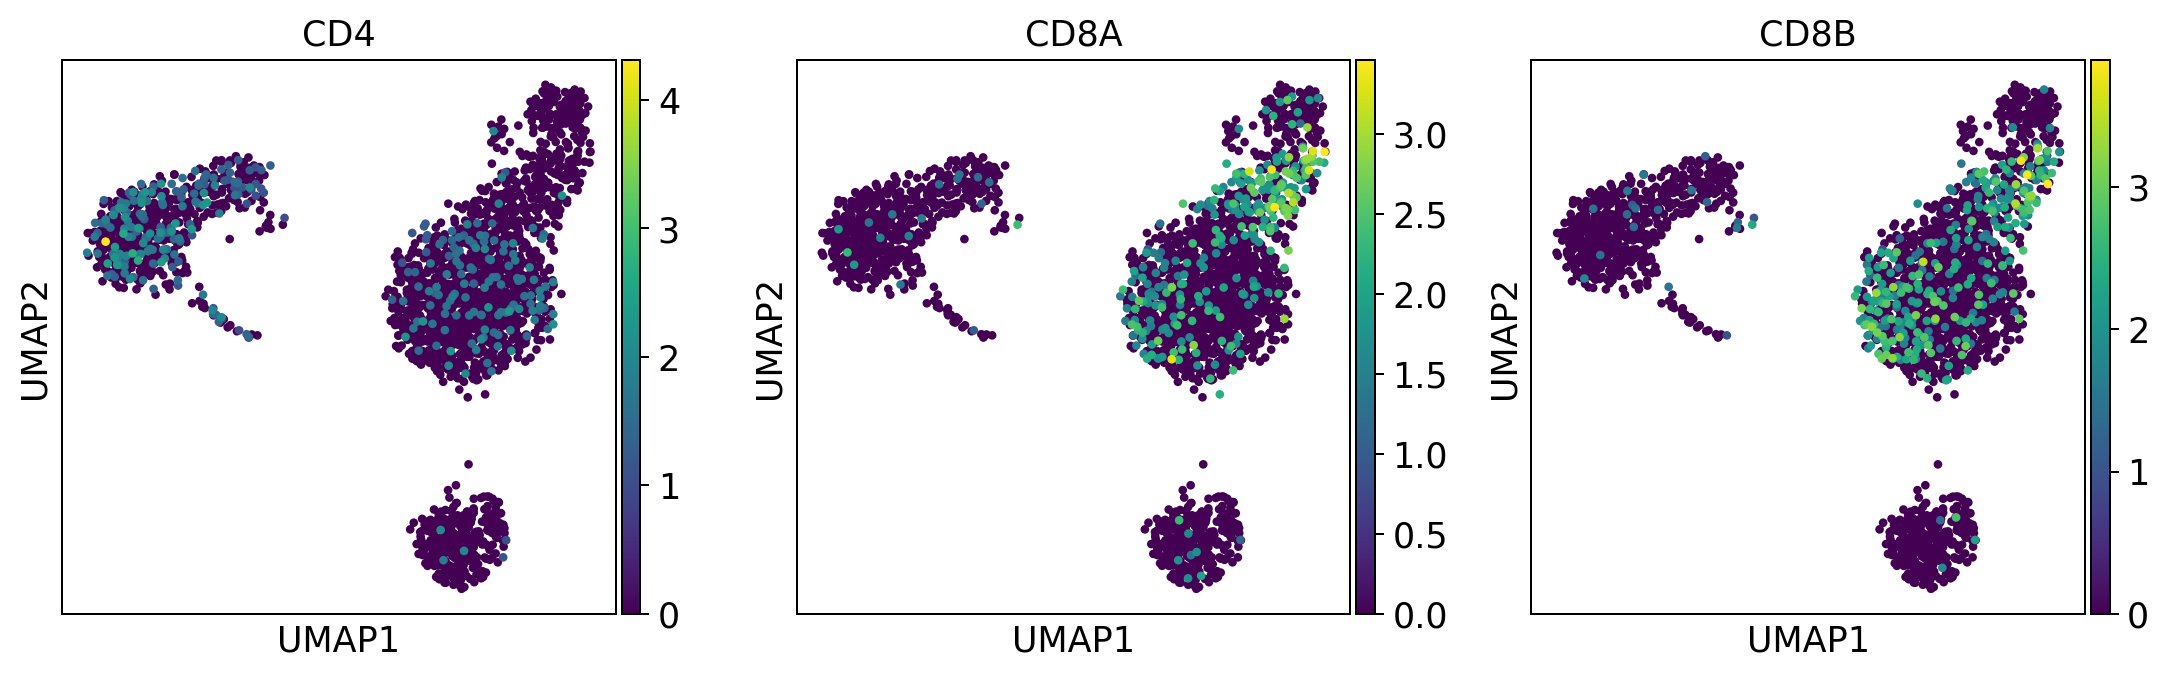

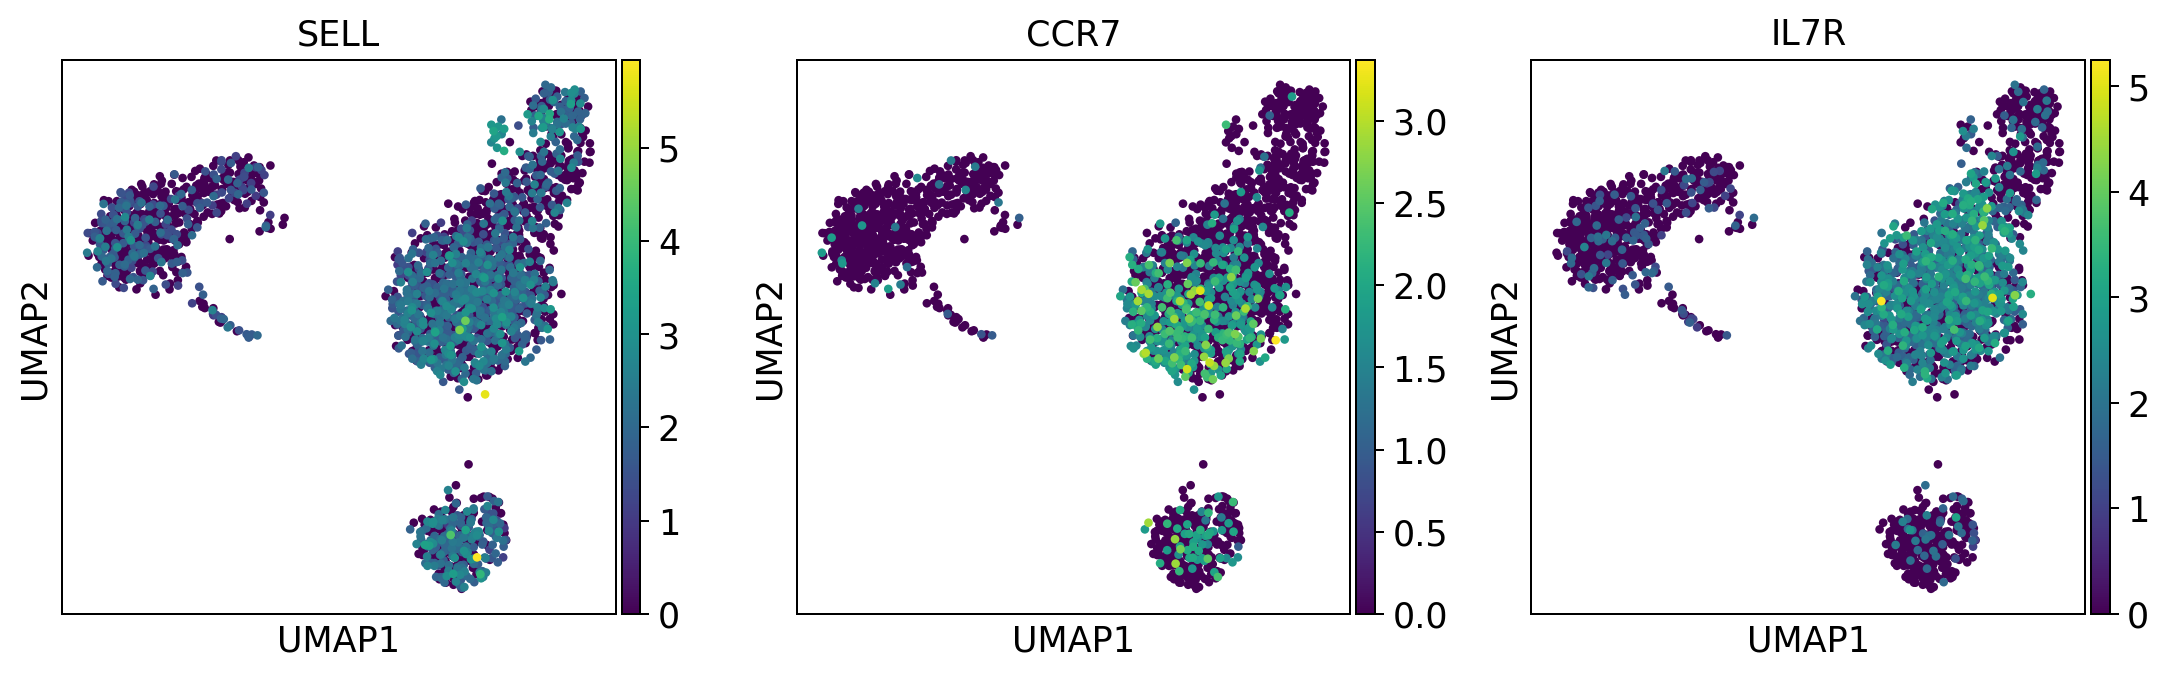

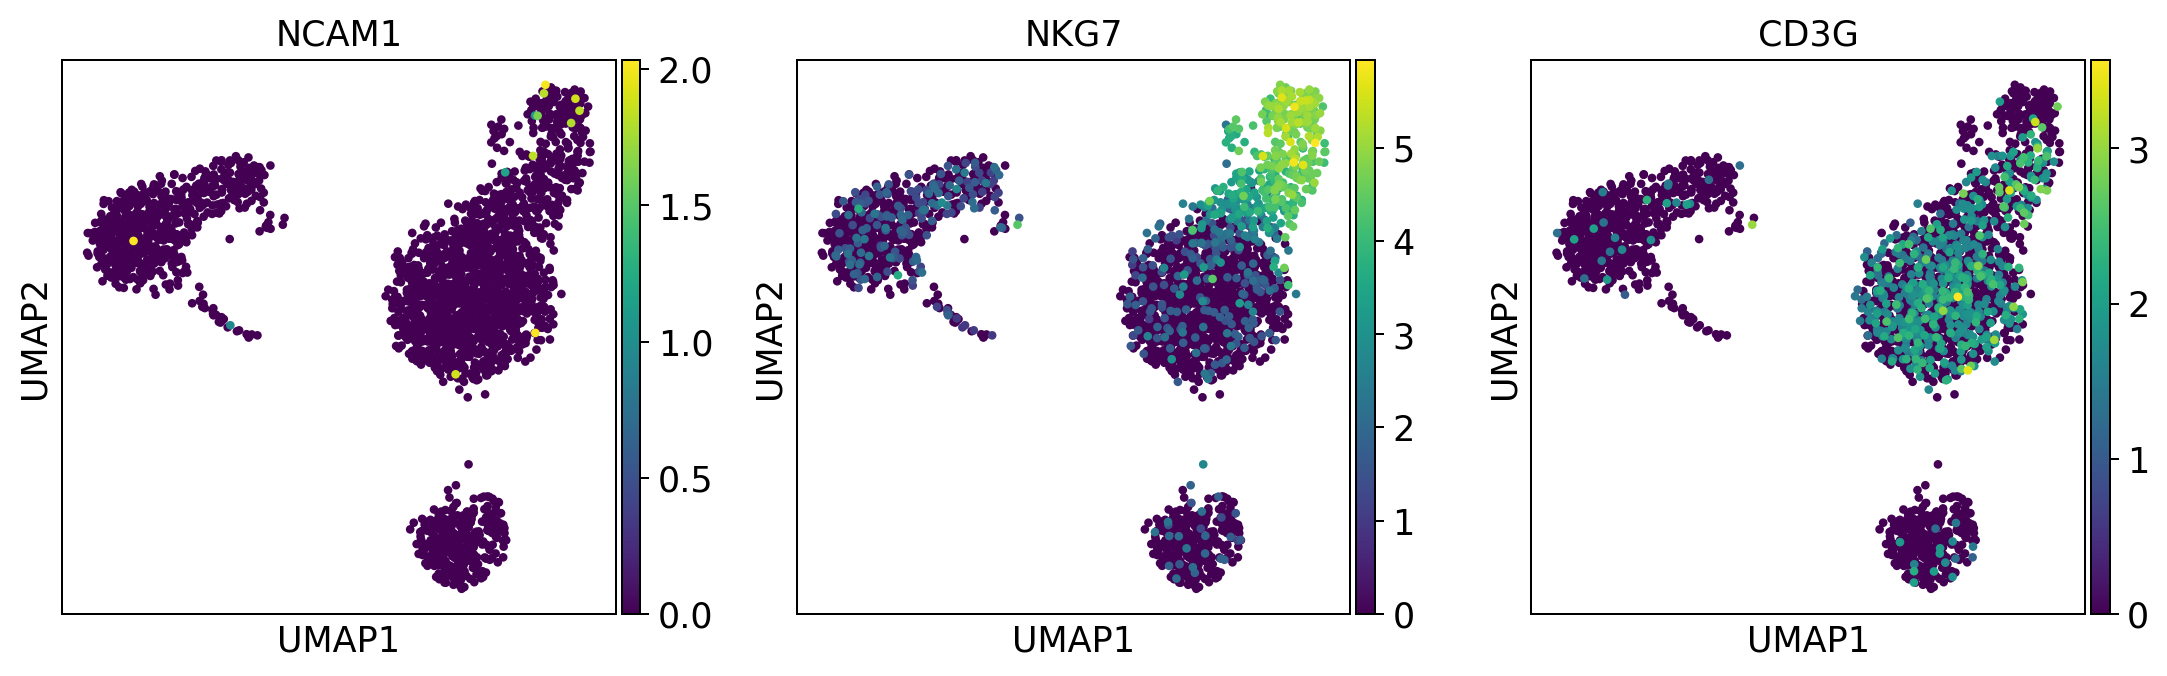

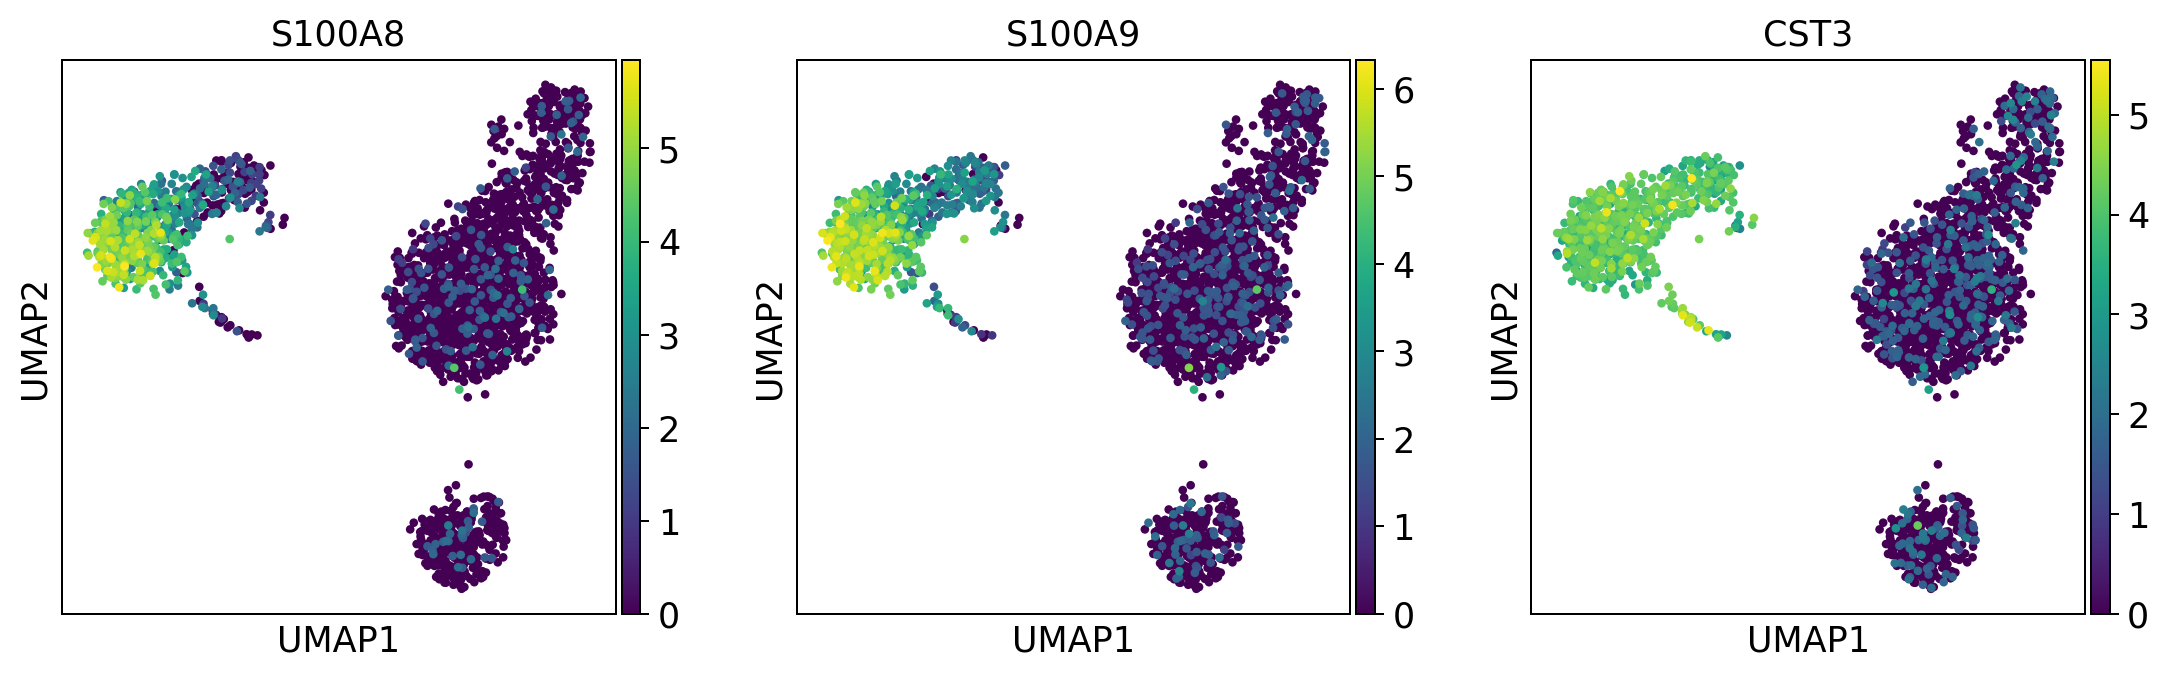

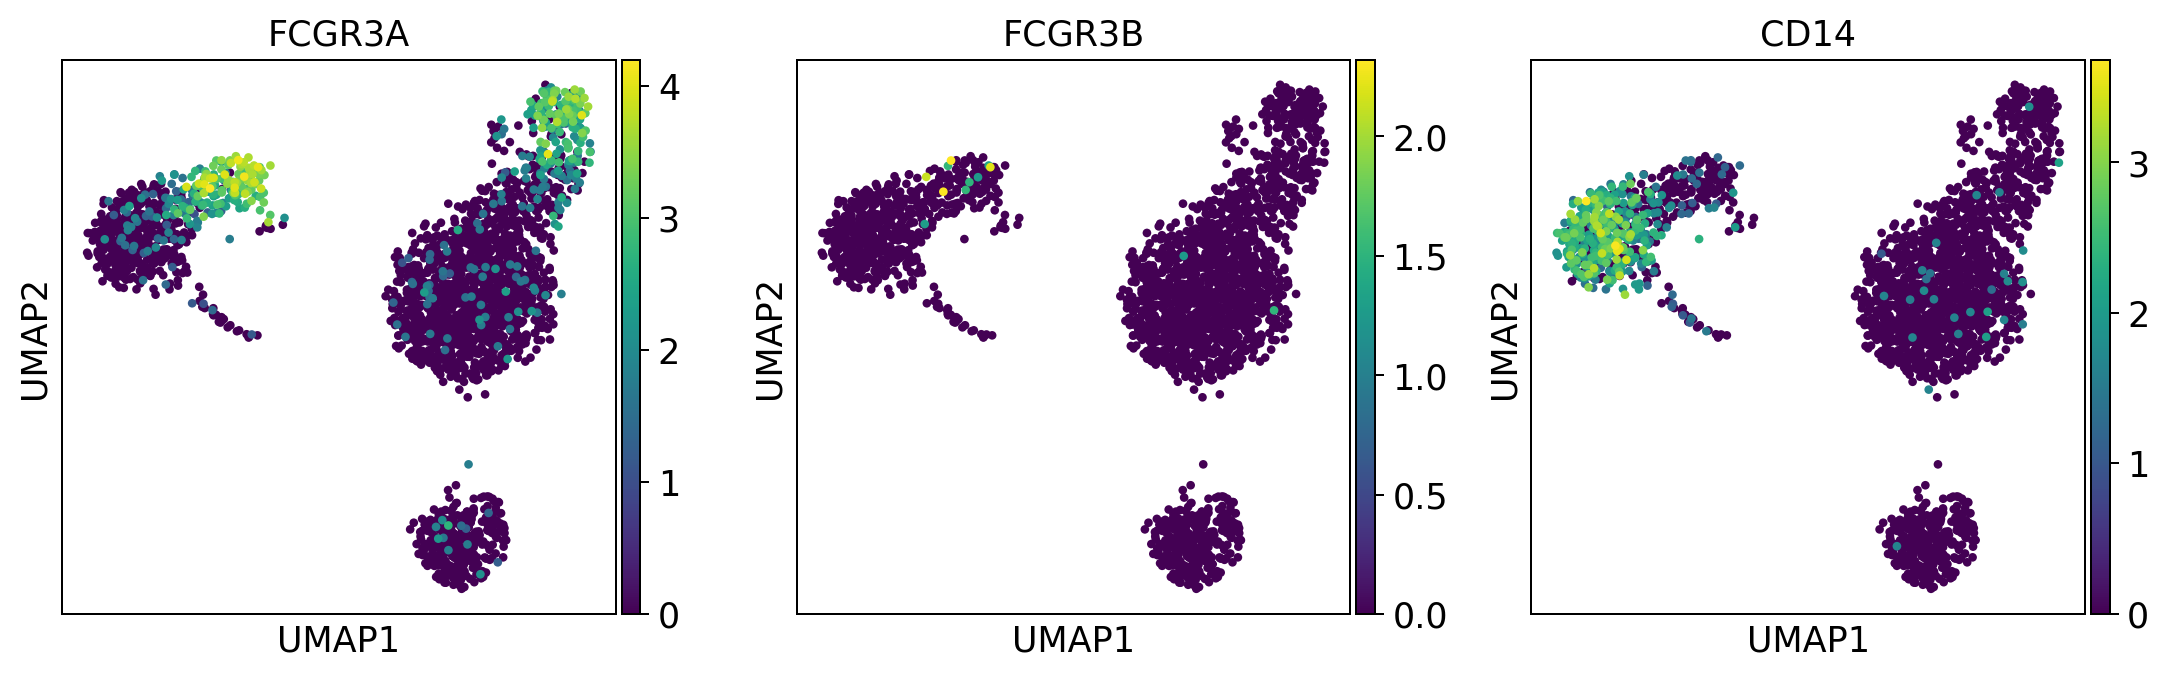

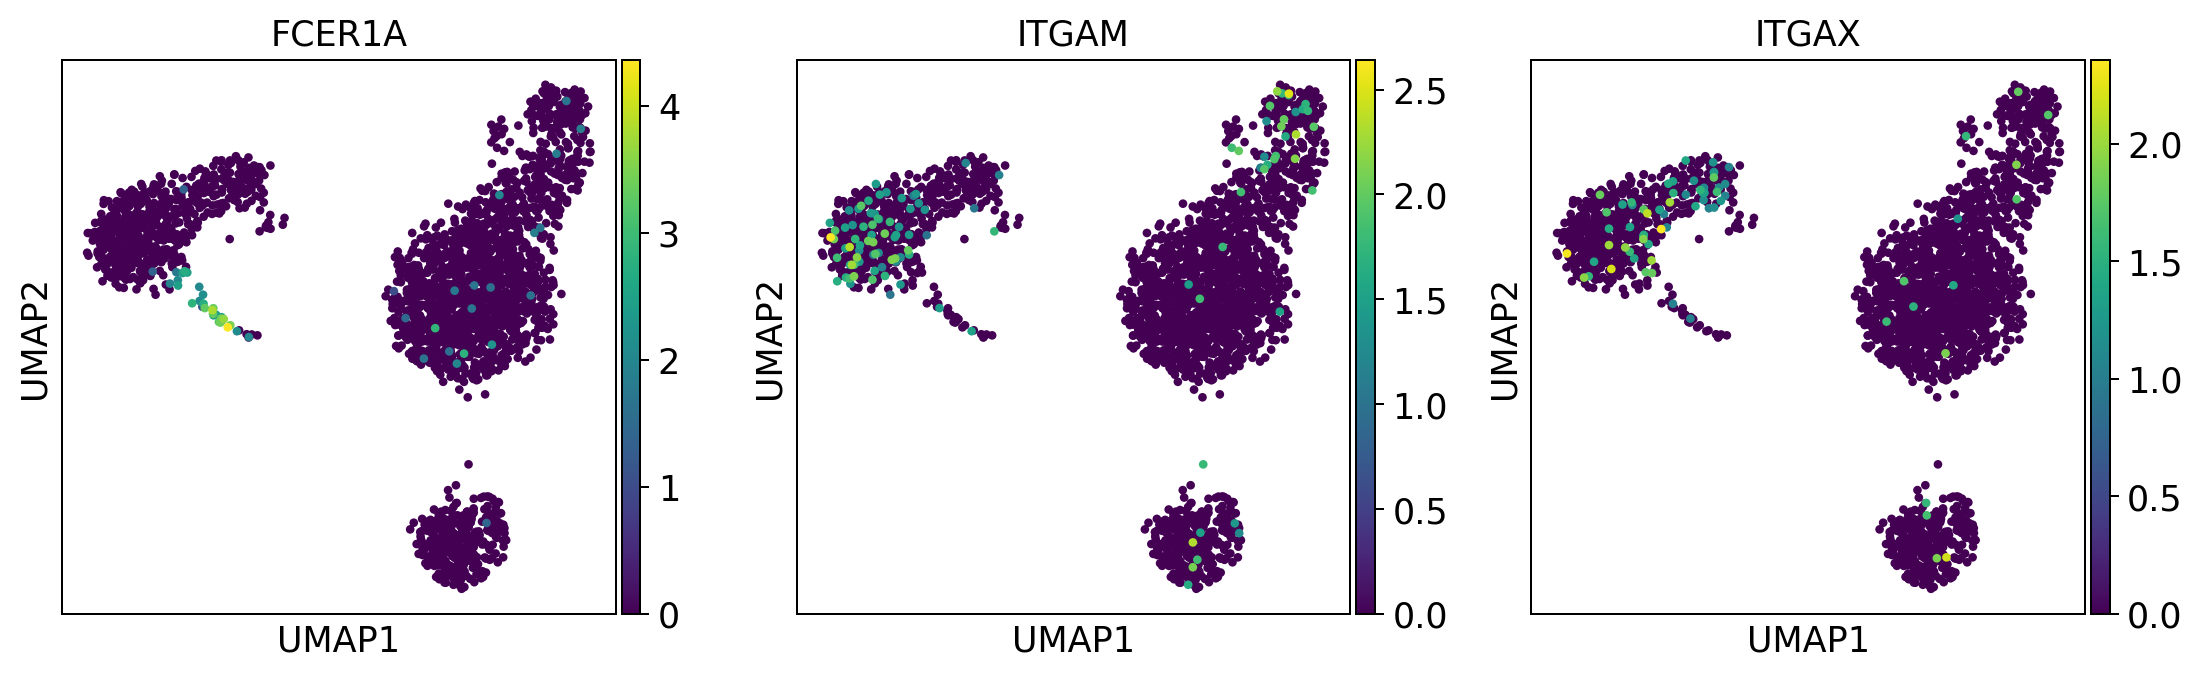

In [10]:
sc.settings.set_figure_params(dpi=90)
#visualize the gene expression as an overlay of the umap
#(this way you can visually identify the clusters with a high expression))
sc.pl.umap(adata, color = b_cells, color_map = 'viridis', ncols = 3)
sc.pl.umap(adata, color = t_cells, color_map = 'viridis', ncols = 3)
sc.pl.umap(adata, color = t_cell_subsets, color_map = 'viridis', ncols = 3)
sc.pl.umap(adata, color = naive_t_cell, color_map = 'viridis', ncols = 3)
sc.pl.umap(adata, color = NK_cells,  color_map = 'viridis',ncols = 3)
sc.pl.umap(adata, color = myeloid_cells,  color_map = 'viridis',ncols = 3)
sc.pl.umap(adata, color = monocytes, color_map = 'viridis', ncols = 3)
sc.pl.umap(adata, color = dendritic_cells, color_map = 'viridis', ncols = 3)

<div class="tag">
Per default scanpy plots the gene expression values saved in adata.raw (this means log1p(cp10k)). This is the reason that we can visualize all of these genes even if they are not contained in the highly variable genes.
</div>

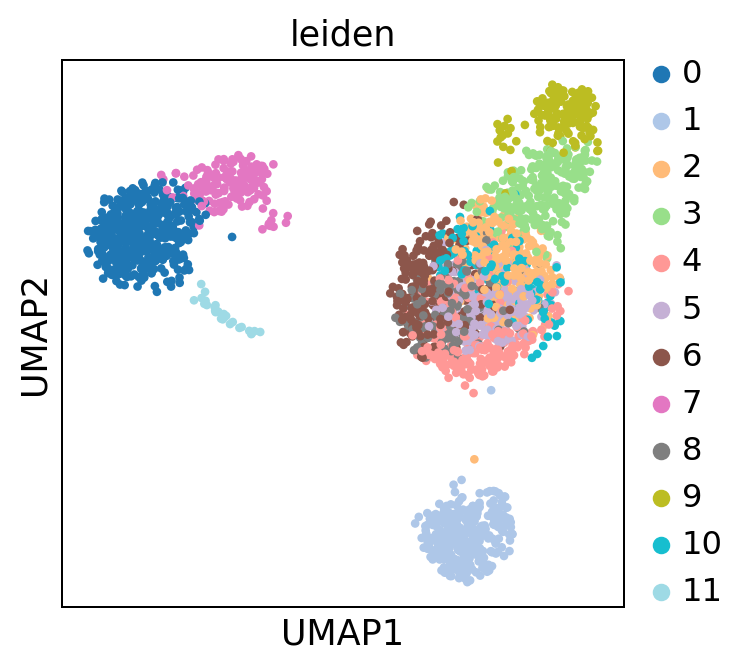

In [11]:
sc.pl.umap(adata, color = 'leiden', palette = 'tab20')

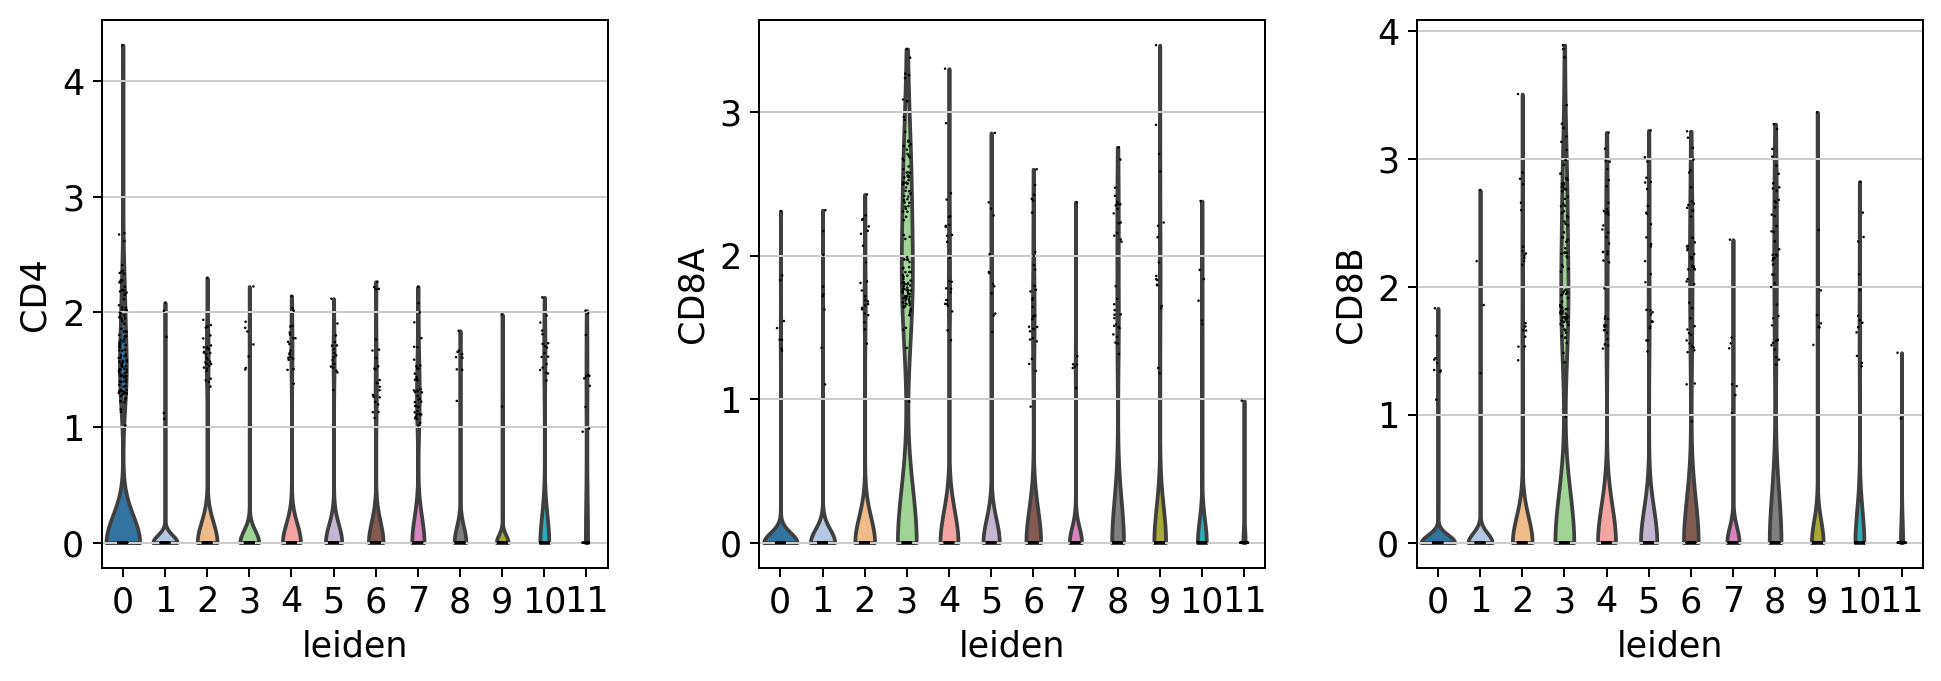

In [12]:
sc.pl.violin(adata, keys= t_cell_subsets, groupby= 'leiden', scale = 'count' )

In [13]:
#write down new cluster names (important order needs to be equivalent to above)
#will label the cell types:

new_cluster_names = ['CD14+ monocyte', #0
                     'B-cell', #1
                     'Mix T-cell', #2
                     'CD8 T-cell', #3
                     'Mix T-cell', #4
                     'Mix T-cell', #5
                     'CD8 T-cell', #6
                     'FCGR3A+ monocyte', #7
                     'CD8 T-cell', #8
                     'NK cells', #9
                     'Mix T-cell', #10
                     'pDC'] #1

bc.tl.annotate_cells_clustering(adata=adata, clustering_label='leiden', new_annotation_label='manual_annotation', new_cluster_labels=new_cluster_names)

<div class="tag">
There are also more advanced methods of cell annotation where mixed clusters (i.e. clusters that contain more than one celltype) can be reclustered seperately and then annoated. Please refer to besca's documentation for more information. 
</div>

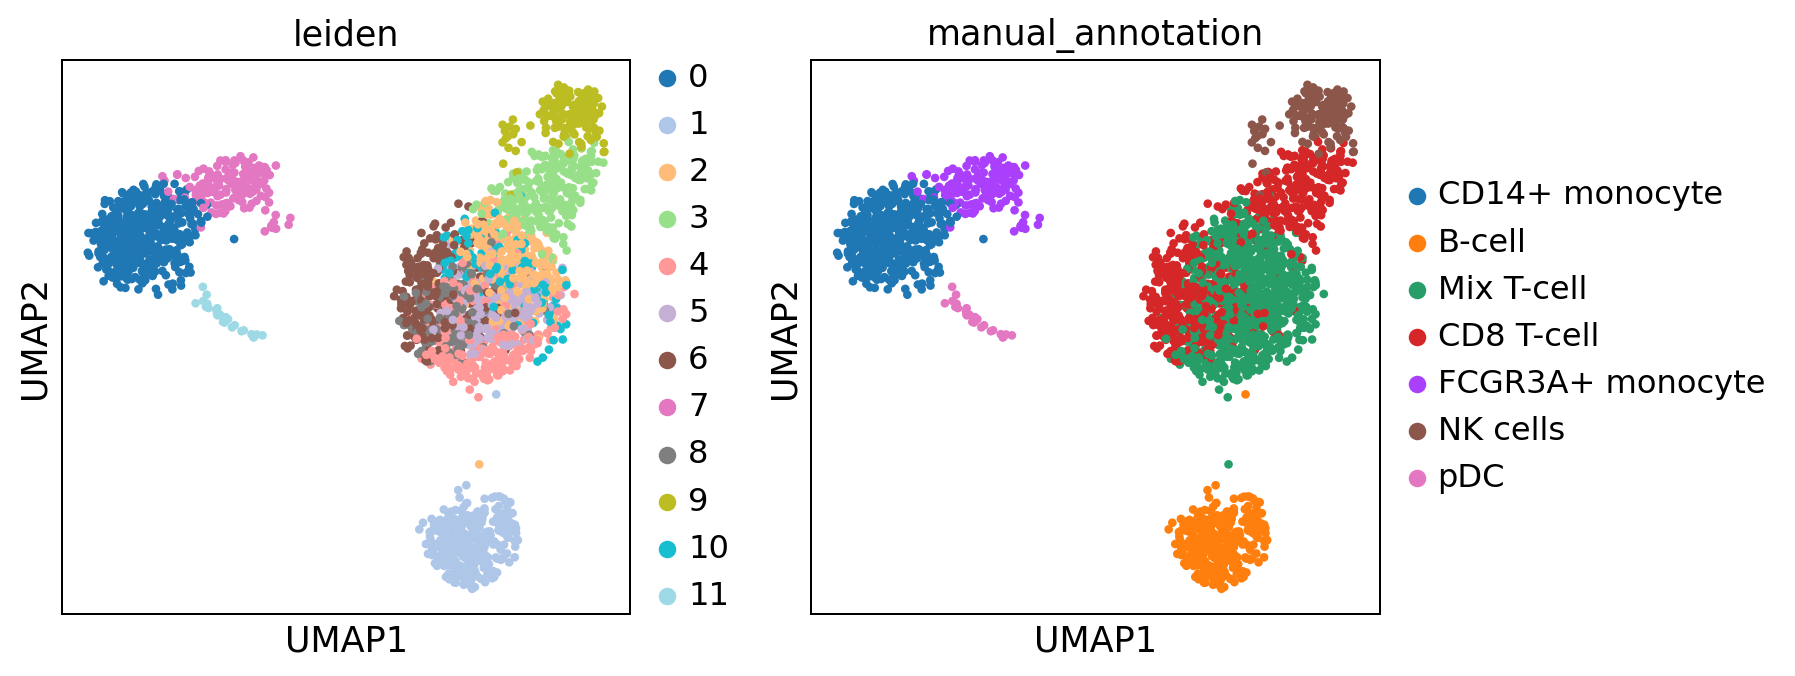

In [14]:
sc.pl.umap(adata, color = ['leiden', 'manual_annotation'], wspace = 0.2)

<div class="tag">
Several clusters have been combined into one celltype. Here only a very rudimentary celltype annotation was performed. Depending on the dataset and the type of analysis this can become far more complex and detailled. 
    
We propose to use a an automated annotation methods to decipher the cluster in an **un-bias** way
    
    
This steps requires to expore initial labelling. This steps within besca will export:
    
    + frac_pos, computing for each gene and cluster the fraction of cells that show a gene expression.
    + average.gct, computing for each gene the average expression per cluster
    
</div>

<div class="fair">
write out required annotation  
`bc.export.labeling(adata=adata, outpath=FILEPATH_TO_FOLDER, column  = 'leiden')`
</div>

In [15]:
bc.export.labeling(adata=adata, outpath='dataset_export/', column  = 'leiden')

mapping of cells to  leiden exported successfully to cell2labels.tsv
average.gct exported successfully to file
fract_pos.gct exported successfully to file


# Hierarchical signature-enrichment based approach for cell type annotation for Hematopoeitic cells


Besca offers a  hierarchical signature-enrichment based approach for cell type annotation.
The initial hierarchy can be visualized below

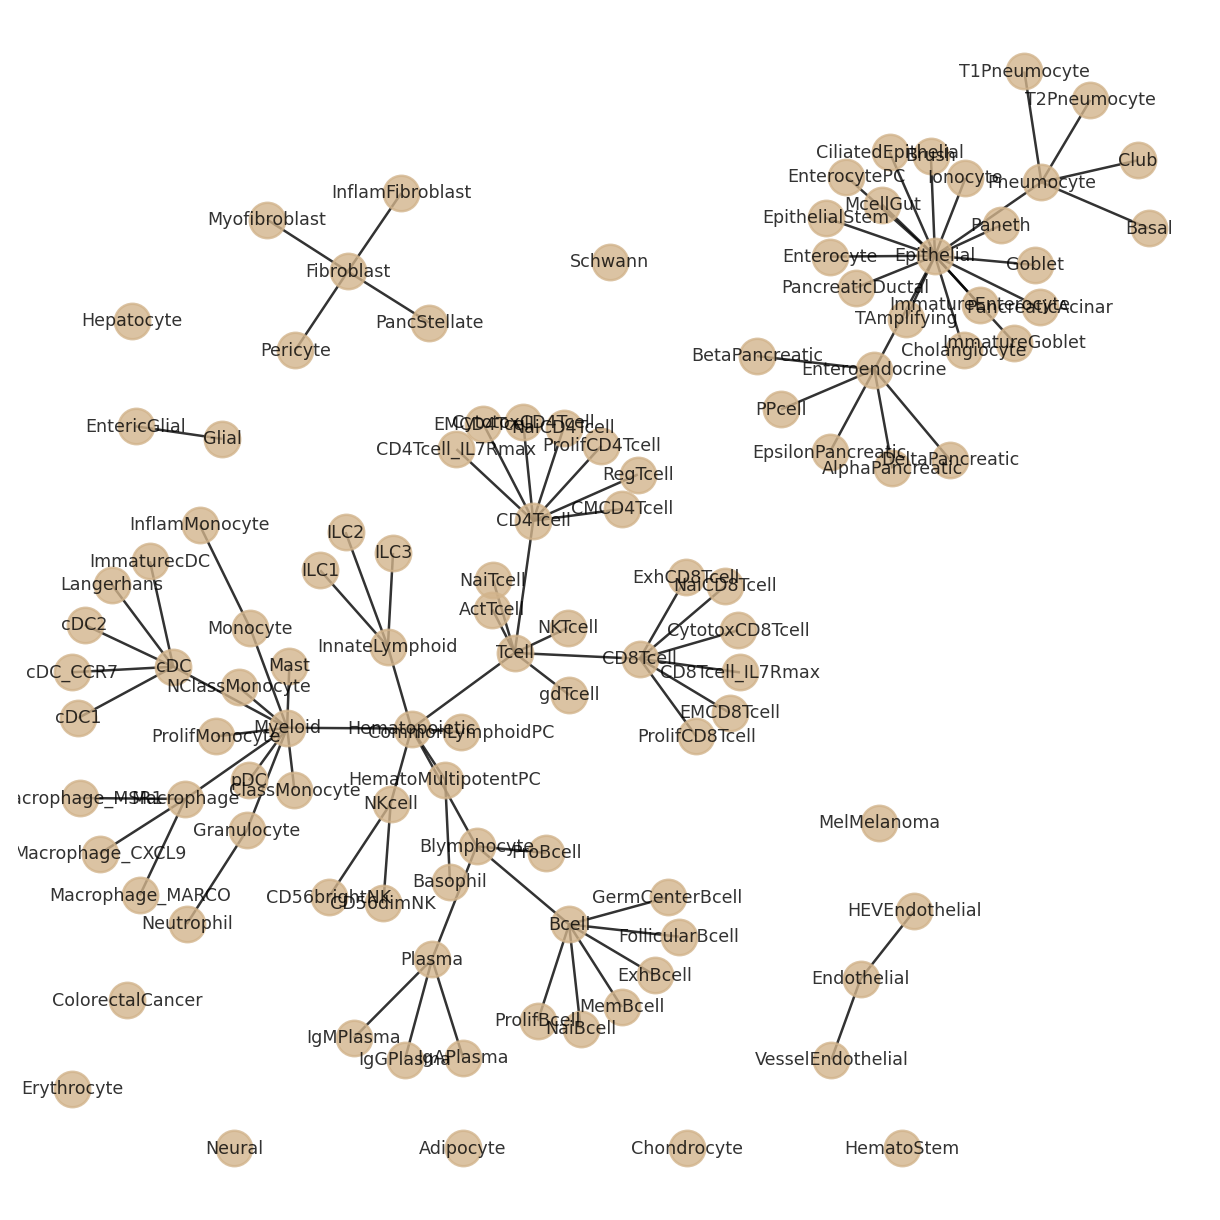

In [16]:
import pkg_resources

config_file = pkg_resources.resource_filename('besca', 'datasets/genesets/CellNames_scseqCMs6_config.tsv')
plt = bc.pl.nomenclature_network(config_file)
plt.show()

## Signature loading and scoring

We load signature directly importing a gmt file.
In case of connection to a GemS database, it is possible to use the GeMs signature loader.


In [19]:
sigconfig,levsk=bc.tl.sig.read_annotconfig(config_file)

In [20]:
gmt_file_anno = pkg_resources.resource_filename('besca', 'datasets/genesets/CellNames_scseqCMs6_sigs.gmt')


mymarkers = bc.tl.sig.read_GMT_sign(gmt_file_anno,directed=False)
mymarkers = bc.tl.sig.filter_siggenes(adata, mymarkers)


bc.tl.sig.combined_signature_score(adata, gmt_file_anno, verbose=False)
#

In [ ]:
sc.settings.set_figure_params(dpi=50)
scores = [x for x in adata.obs.columns if 'scanpy' in x]
sc.pl.umap(adata, color= scores, color_map = 'viridis')

<div class="tag">


Signature can be observed in detailled to assess possible cluster assignation.
However Besca offers to use a signature-based hierarchical annotation to build on know relations (see network above). 
This annotation is based on the mann whithney scoring of the positive fraction of cell and signatures provided.
    
</div>

In [22]:

mymarkers['Ubi'] = ['B2M','ACTB', 'GAPDH'] ### used for cutoff adjustment to individual dataset, can be modified

f=pd.read_csv("dataset_export/fract_pos.gct",sep="\t",skiprows=2)
df=bc.tl.sig.score_mw(f,mymarkers)

myc=np.median(df.loc['Ubi',:]*0.5) ### Set a cutoff based on Ubi and scale with values from config file

One can observe the resulting log10(pvalues) obtained

In [24]:
df.iloc[0:3,0:7]


10          3          4         1         6        7  \
Bcell          1.56094    4.13485    2.95624   69.0433   10.5977  7.80649   
Fibroblast   0.0190186   0.401073   0.195534  0.155626  0.789622  1.19473   
Endothelial    0.26813  0.0966688  0.0468776  0.116507   1.71538  9.77757   

                    2  
Bcell         2.91941  
Fibroblast   0.117674  
Endothelial  0.718209

In [25]:
#Cluster attribution based on cutoff
df=df.drop('Ubi')
sigscores={}
for mysig in list(df.index):
    sigscores[mysig]=bc.tl.sig.getset(df,mysig,sigconfig.loc[mysig,'Cutoff']*myc)

In [26]:
sigconfig.loc["CD8Tcell","Cutoff"]=1.2
# RECOMPUTING SIG SCORE WITH NEW CUTOFF
sigscores={}
for mysig in list(df.index):
    sigscores[mysig]=bc.tl.sig.getset(df,mysig,sigconfig.loc[mysig,'Cutoff']*myc)
    
    
cnames=bc.tl.sig.make_anno(df,sigscores,sigconfig,levsk)
cnames

celltype0    celltype1       celltype2        celltype3
10  Hematopoietic        Tcell        CD4Tcell      NaiCD4Tcell
3   Hematopoietic        Tcell        CD8Tcell  CytotoxCD8Tcell
4   Hematopoietic        Tcell        CD4Tcell      NaiCD4Tcell
1   Hematopoietic  Blymphocyte           Bcell         NaiBcell
6   Hematopoietic        Tcell        CD8Tcell      NaiCD8Tcell
7   Hematopoietic      Myeloid  NClassMonocyte   NClassMonocyte
2   Hematopoietic        Tcell        CD4Tcell       EMCD4Tcell
8   Hematopoietic        Tcell        CD8Tcell      NaiCD8Tcell
11  Hematopoietic      Myeloid             cDC             cDC2
9   Hematopoietic       NKcell       CD56dimNK        CD56dimNK
0   Hematopoietic      Myeloid   ClassMonocyte    ClassMonocyte
5   Hematopoietic        Tcell        CD4Tcell      NaiCD4Tcell

In [27]:
label_files = pkg_resources.resource_filename('besca', '/datasets/nomenclature/CellTypes_v1.tsv')

cnamesDBlabel = bc.tl.sig.obtain_dblabel( label_files, cnames )
cnamesDBlabel

celltype0                celltype1  \
10  hematopoietic cell                   T cell   
3   hematopoietic cell                   T cell   
4   hematopoietic cell                   T cell   
1   hematopoietic cell  lymphocyte of B lineage   
6   hematopoietic cell                   T cell   
7   hematopoietic cell        myeloid leukocyte   
2   hematopoietic cell                   T cell   
8   hematopoietic cell                   T cell   
11  hematopoietic cell        myeloid leukocyte   
9   hematopoietic cell      natural killer cell   
0   hematopoietic cell        myeloid leukocyte   
5   hematopoietic cell                   T cell   

                                 celltype2  \
10         CD4-positive, alpha-beta T cell   
3          CD8-positive, alpha-beta T cell   
4          CD4-positive, alpha-beta T cell   
1                                   B cell   
6          CD8-positive, alpha-beta T cell   
7                   non-classical monocyte   
2          CD4-positive, alpha-beta T cell   
8          CD8-positive, alpha-beta T cell   
11                  myeloid dendritic cell   
9   cytotoxic CD56-dim natural killer cell   
0                       classical monocyte   
5          CD4-positive, alpha-beta T cell   

                                            celltype3  
10  naive thymus-derived CD4-positive, alpha-beta ...  
3           CD8-positive, alpha-beta cytotoxic T cell  
4   naive thymus-derived CD4-positive, alpha-beta ...  
1                                        naive B cell  
6   naive thymus-derived CD8-positive, alpha-beta ...  
7                              non-classical monocyte  
2     effector memory CD4-positive, alpha-beta T cell  
8   naive thymus-derived CD8-positive, alpha-beta ...  
11               CD1c-positive myeloid dendritic cell  
9              cytotoxic CD56-dim natural killer cell  
0                                  classical monocyte  
5   naive thymus-derived CD4-positive, alpha-beta ...

In [28]:
adata.obs['celltype0']=bc.tl.sig.add_anno(adata,cnamesDBlabel,'celltype0','leiden')
adata.obs['celltype1']=bc.tl.sig.add_anno(adata,cnamesDBlabel,'celltype1','leiden')
adata.obs['celltype2']=bc.tl.sig.add_anno(adata,cnamesDBlabel,'celltype2','leiden')
adata.obs['celltype3']=bc.tl.sig.add_anno(adata,cnamesDBlabel,'celltype3','leiden')

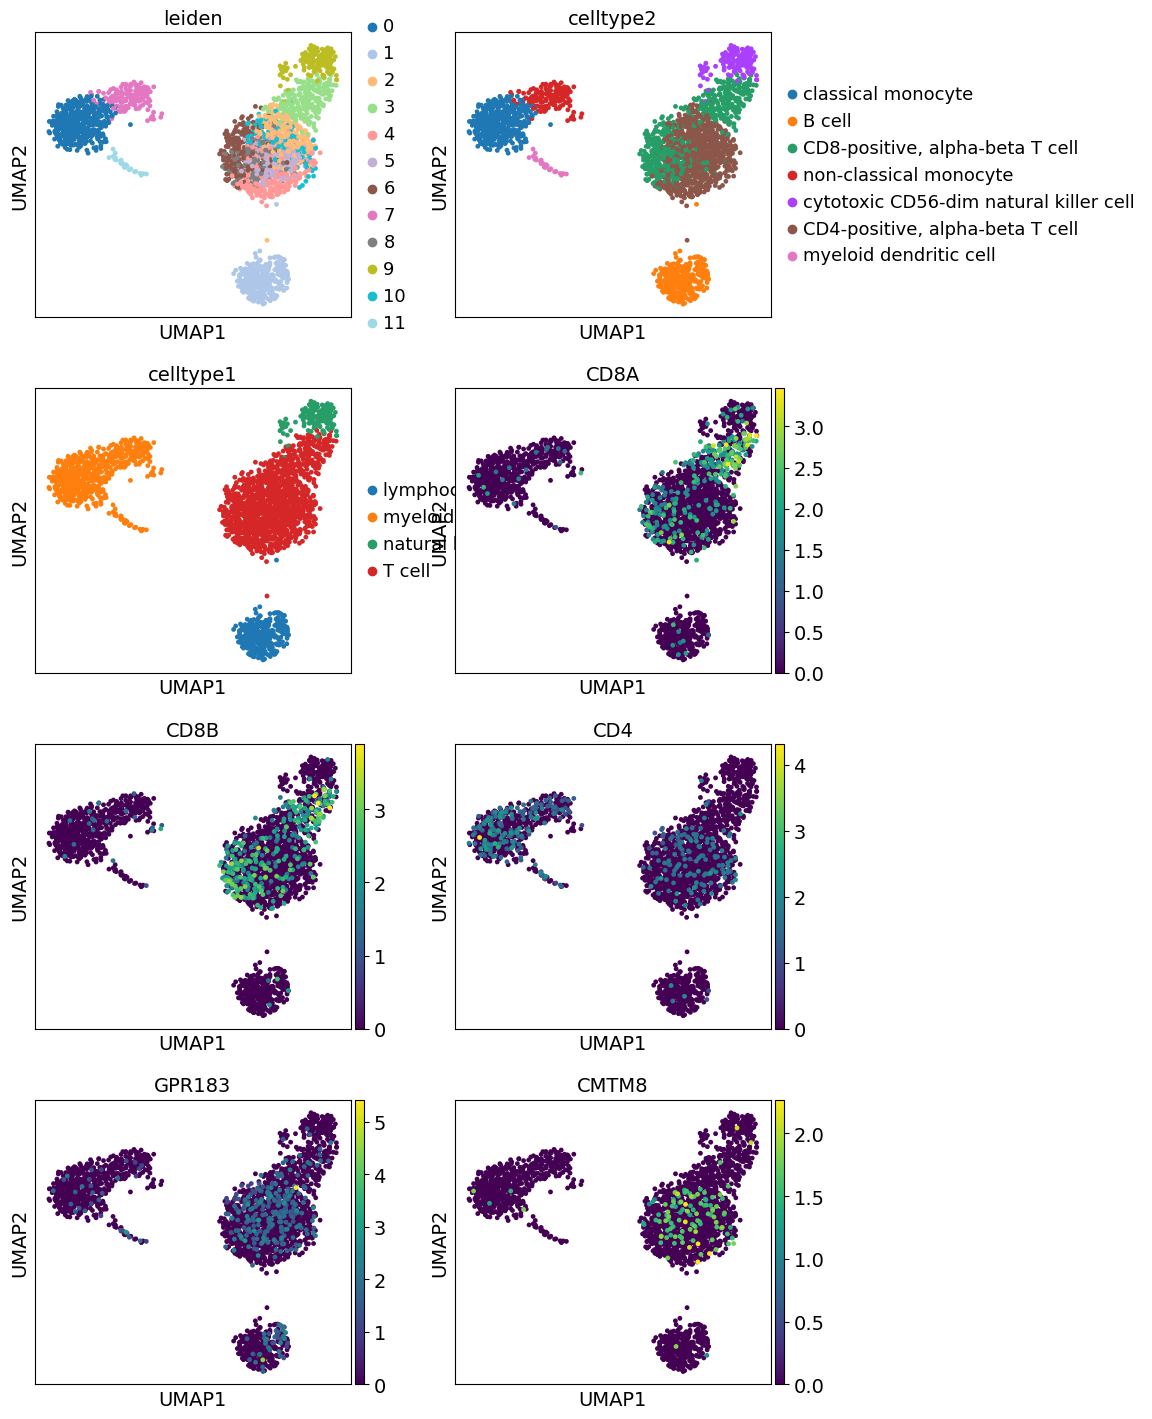

In [29]:
sc.pl.umap(adata,color=['leiden','celltype2', 'celltype1', 
                        'CD8A', 'CD8B', # CD8 T cell markers
                        'CD4' ,    'GPR183', 'CMTM8' # CD4 t cell markers
                       ], ncols=2) #,'celltype3'

<div class="tag">
Here we believe some clusters of T cells are still mixed and that a more refined annotation can be done if recluster the lymphocytes. 
The similar procedure is applied below
</div>

## Reclustering Lymphocytes



In [30]:
adata.obs['leiden_original'] = adata.obs['leiden'].copy()


In [31]:
adata_rc = bc.tl.rc.recluster ( adata, celltype_label = 'celltype1', 
                               celltype= ('T cell',  'natural killer cell'), resolution=1.3)

In total 1478 highly variable genes selected within cluster


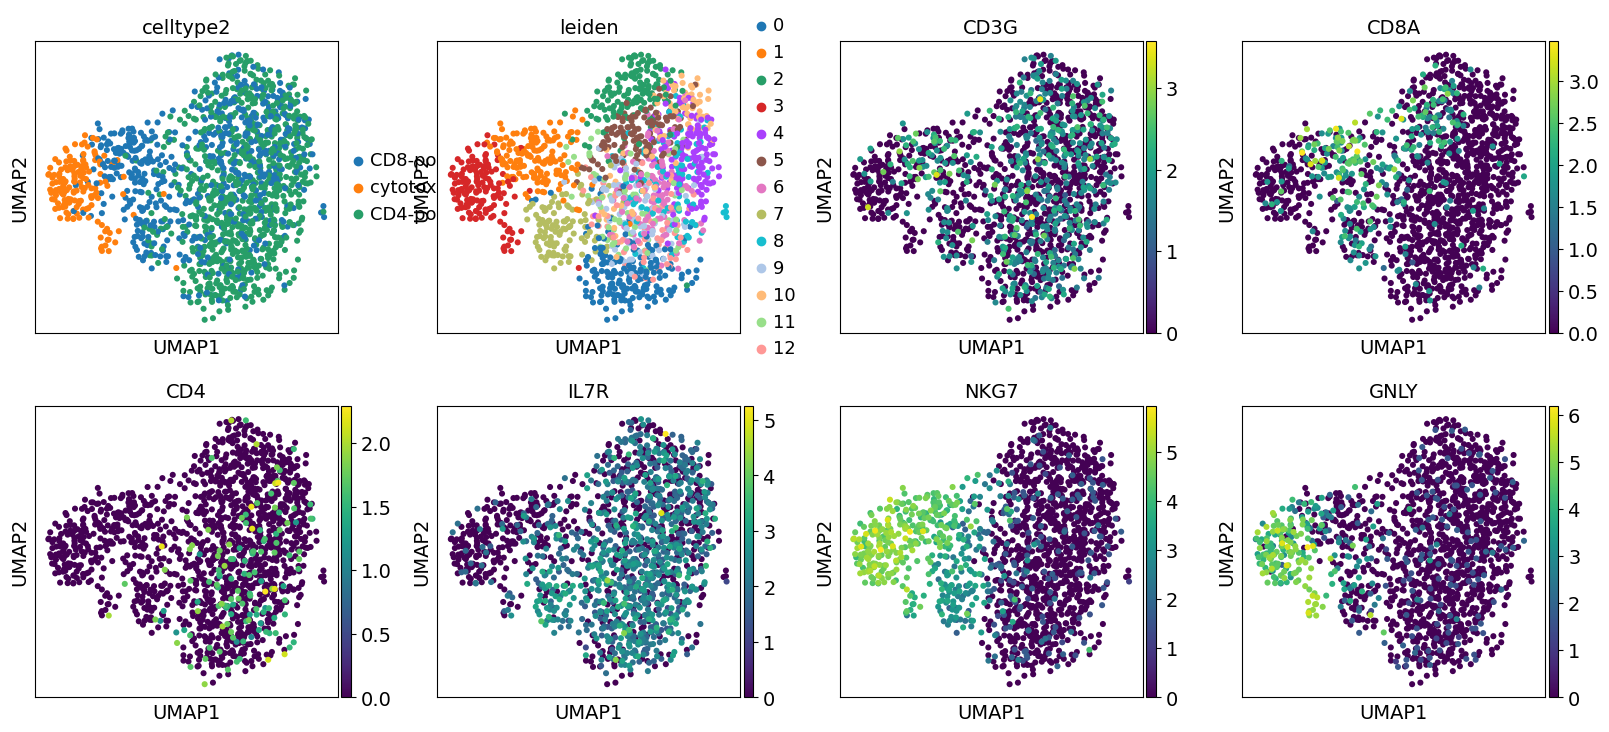

In [32]:
sc.pl.umap( adata_rc, color = ['celltype2','leiden', 
                              # Some markers
                              'CD3G', 'CD8A', 'CD4', 'IL7R', 'NKG7', 'GNLY'])

<div class="tag">
Exporting the additional labelling allows to regenerate frac_pos required file for the annotartion function.
</div>

In [33]:
adata_rc = bc.st.additional_labeling(adata_rc, 'leiden', 'Leiden_Reclustering', 'Leiden Reclustering on Lymphocytes', 'Julienla', 'dataset_export')

rank genes per label calculated using method wilcoxon.
mapping of cells to  leiden exported successfully to cell2labels.tsv
average.gct exported successfully to file
fract_pos.gct exported successfully to file
labelinfo.tsv successfully written out
dataset_export/labelings/Leiden_Reclustering/WilxRank.gct written out
dataset_export/labelings/Leiden_Reclustering/WilxRank.pvalues.gct written out
dataset_export/labelings/Leiden_Reclustering/WilxRank.logFC.gct written out


In [34]:
mymarkers['Ubi'] = ['B2M','ACTB', 'GAPDH'] 
clusters = 'Leiden_Reclustering'
f=pd.read_csv('dataset_export' + "/labelings/"+clusters+"/fract_pos.gct",sep="\t",skiprows=2)
df=bc.tl.sig.score_mw(f,mymarkers)
myc=np.median(df.loc['Ubi',:]*0.5) ### Set a cutoff based on Ubi and scale with values from config file

In [35]:
# RECOMPUTING SIG SCORE WITH NEW CUTOFF
df=df.drop('Ubi')
sigscores={}
for mysig in list(df.index):
    sigscores[mysig]=bc.tl.sig.getset(df,mysig,sigconfig.loc[mysig,'Cutoff']*myc)
    #sigscores[mysig]=bc.tl.sig.getset(df,mysig,10)

In [36]:
toExclude = [x  for x in levsk[1] if not x == 'Tcell' and not x == 'NKcell']

cnames=bc.tl.sig.make_anno(df,sigscores,sigconfig,levsk,  toexclude= toExclude)

cnamesDBlabel = bc.tl.sig.obtain_dblabel(label_files, cnames )


adata_rc.obs['celltype0']=bc.tl.sig.add_anno(adata_rc,cnamesDBlabel,'celltype0','leiden')
adata_rc.obs['celltype2']=bc.tl.sig.add_anno(adata_rc,cnamesDBlabel,'celltype2','leiden')
adata_rc.obs['celltype3']=bc.tl.sig.add_anno(adata_rc,cnamesDBlabel,'celltype3','leiden')

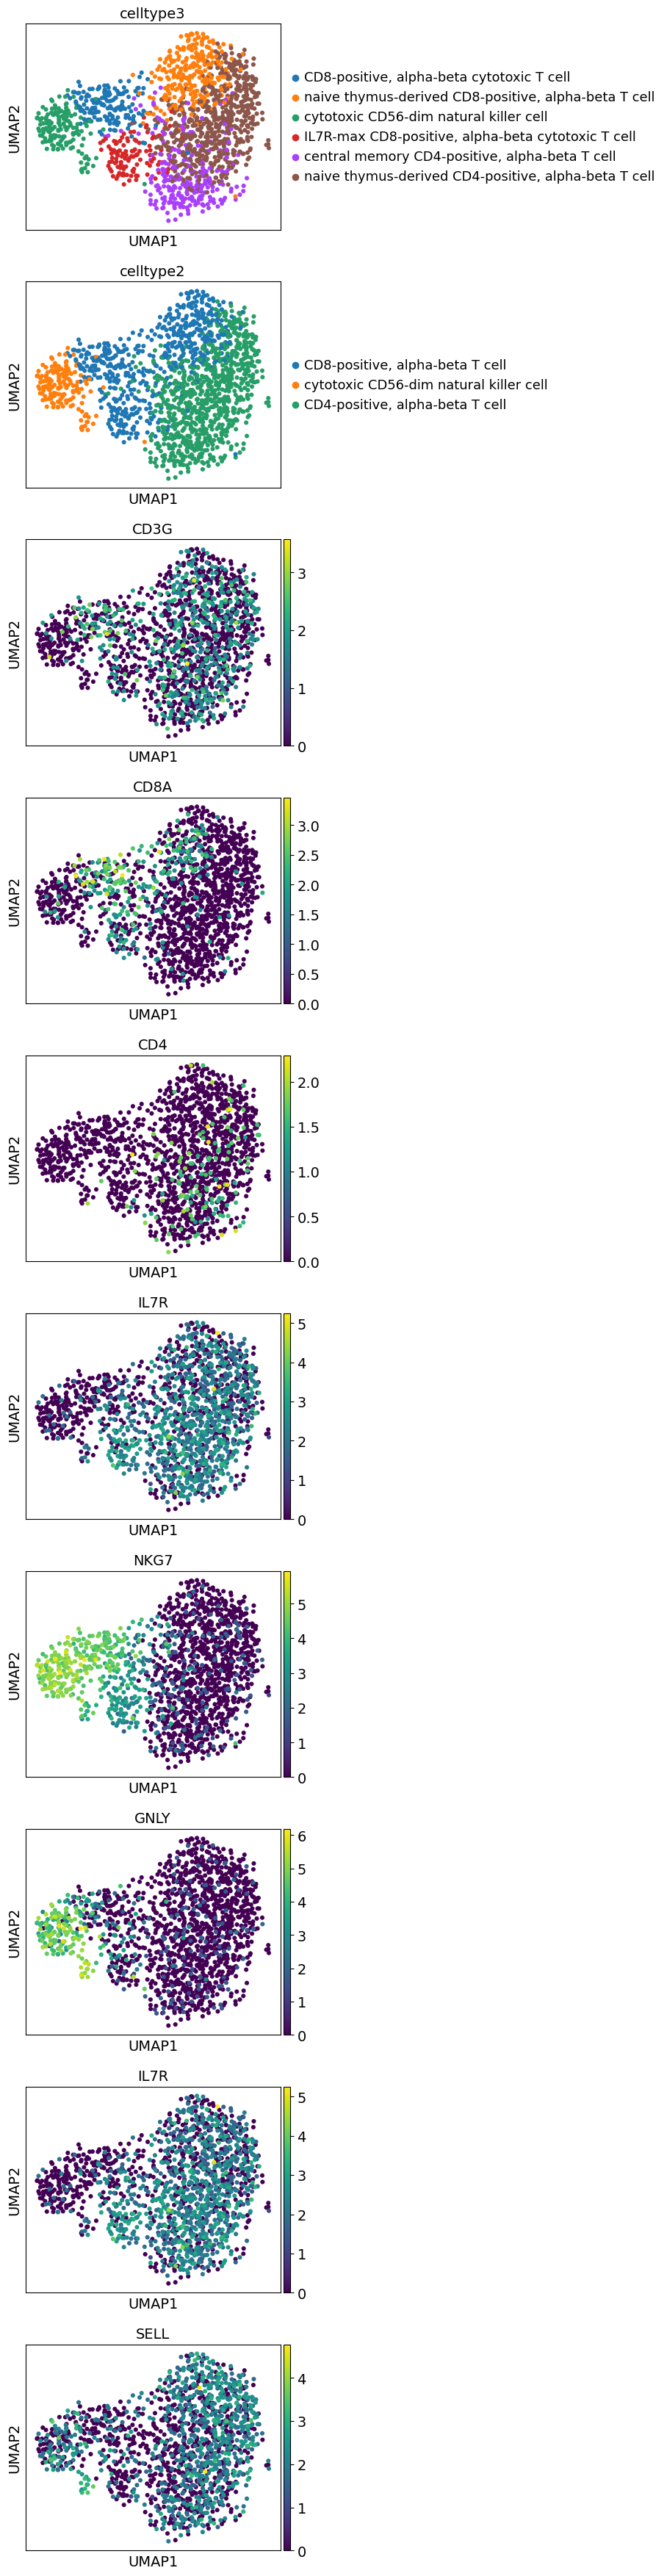

In [37]:
sc.pl.umap(adata_rc,color=['celltype3', 'celltype2',
                           'CD3G', 'CD8A', 'CD4', 'IL7R', 'NKG7', 'GNLY', #, 'S100A'
                           'IL7R', 'SELL'
                          ], 
           ncols=1)

In [38]:
names_2 = []
names_3 = []
for i in range( cnames.shape[0]) :
    # Orderigng lexo. order
    names_2 += [cnames['celltype2'][str(i)]]
    names_3 += [cnames['celltype3'][str(i)]]

In [39]:
bc.tl.rc.annotate_new_cellnames( adata, adata_rc, names = names_2, new_label='celltype2', method = 'leiden')

bc.tl.rc.annotate_new_cellnames( adata, adata_rc, names = names_3, new_label='celltype3', method = 'leiden')

NOTE: overwriting labels for the selected cells saved in adata.obs.celltype2 with the new labels
NOTE: overwriting labels for the selected cells saved in adata.obs.celltype3 with the new labels


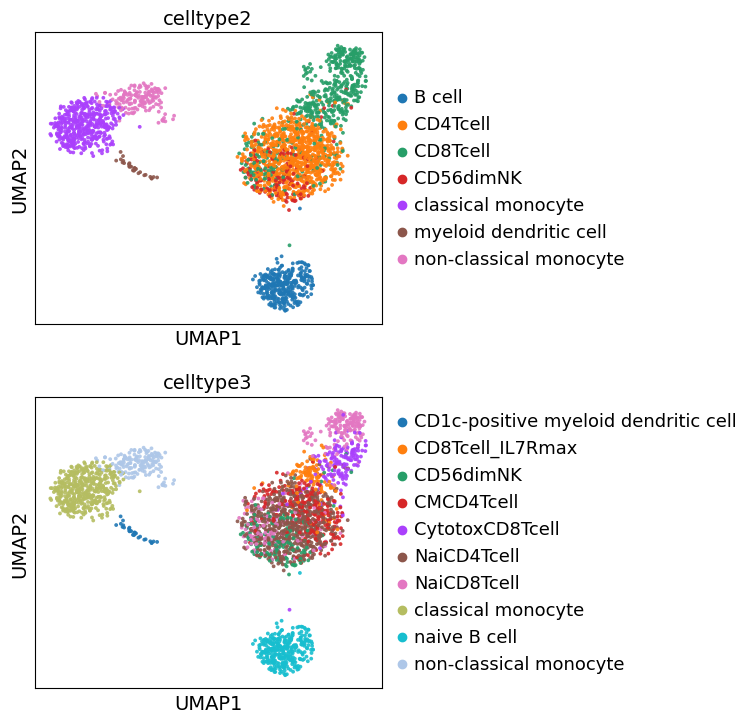

In [40]:
sc.pl.umap(adata,color=['celltype2',
                       'celltype3'], ncols=1, alpha= 0.9, size= 30) 

<div class="tag">
Here we write out the celltype annotation so that we can use reload it in later analysis steps. There is a correspondng besca function for reloading the annotation.
</div>

In [41]:
#save AnnData Object for comparision purposes
adata.write('dataset_export/data_pbmc_processed_annotated.h5ad')

## unbiased marker genes for each cluster

In [42]:
#perform differential gene expression between each louvain cluster and all other cells using scanpy
sc.tl.rank_genes_groups(adata, groupby='celltype3')

categories: 0, 1, 2, etc.
var_group_labels: CD1c-positive myeloid dendritic cell, CD8Tcell_IL7Rmax, CD56dimNK, etc.


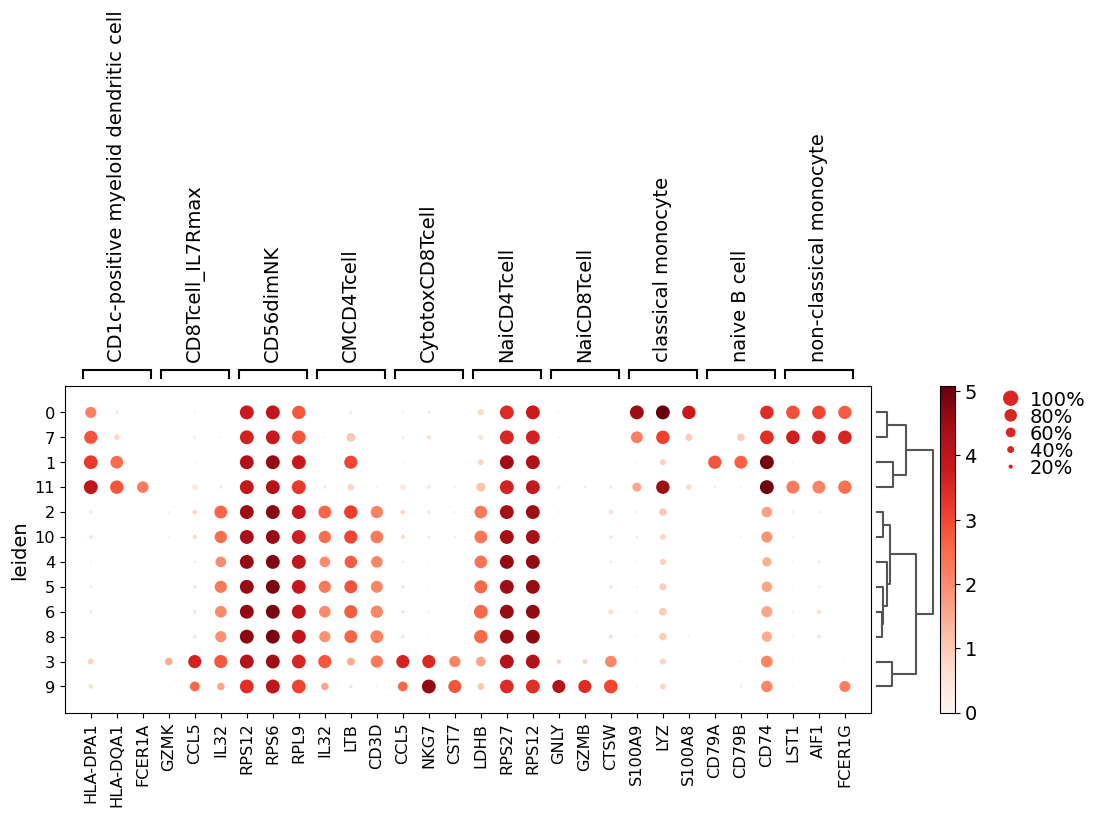

In [43]:
#visualize the top 3 marker genes as a dot plot
sc.pl.rank_genes_groups_dotplot(adata, n_genes=3, groupby = 'leiden')

categories: 0, 1, 2, etc.
var_group_labels: CD1c-positive myeloid dendritic cell, CD8Tcell_IL7Rmax, CD56dimNK, etc.


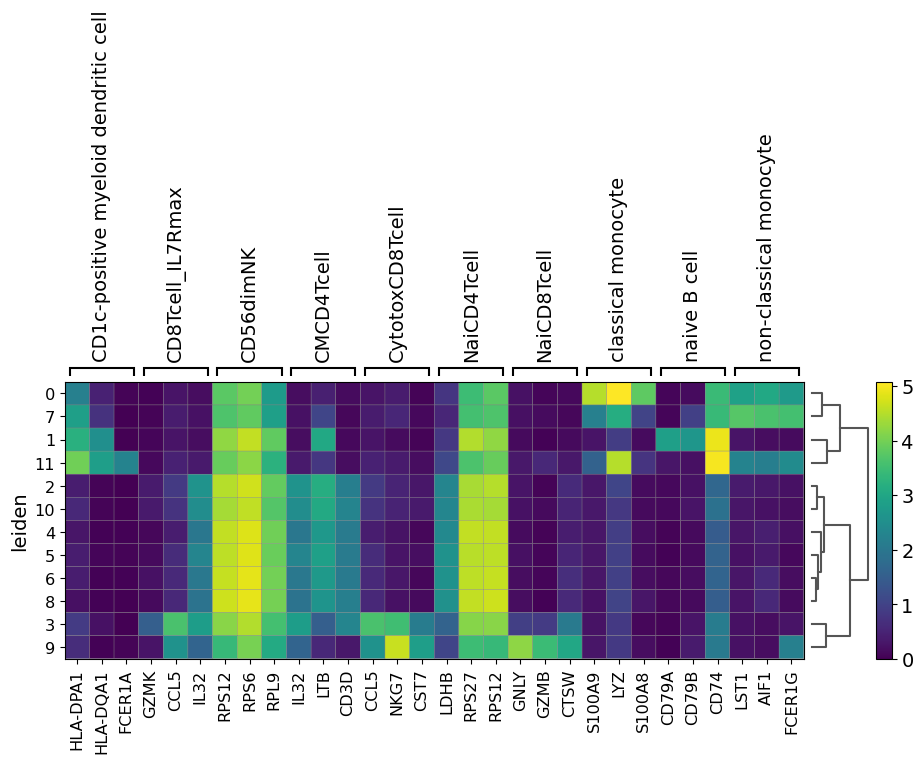

In [44]:
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=3, use_raw=True, groupby = 'leiden')

categories: 0, 1, 2, etc.
var_group_labels: CD1c-positive myeloid dendritic cell, CD8Tcell_IL7Rmax, CD56dimNK, etc.


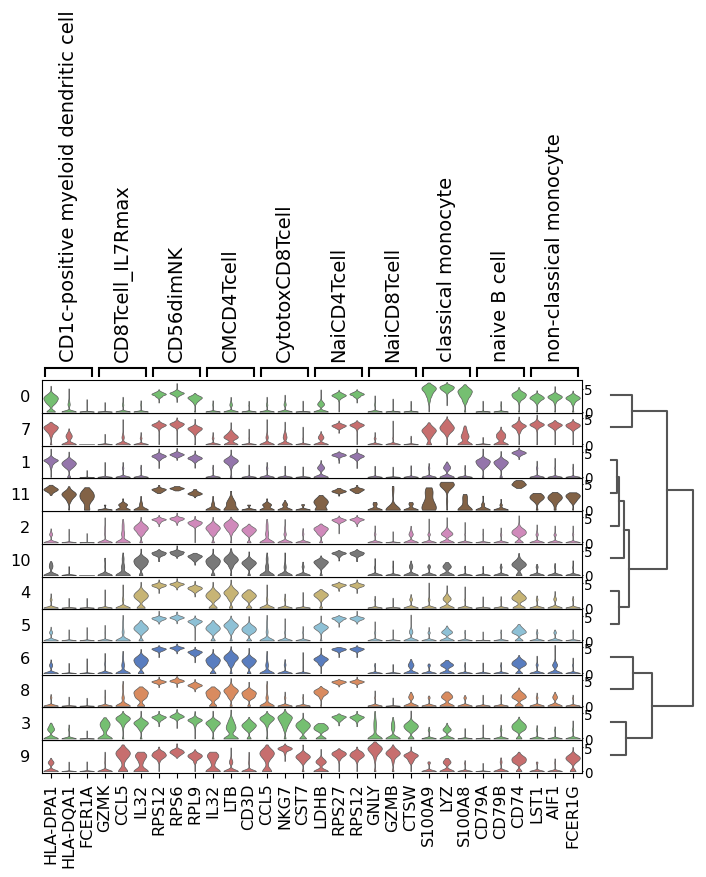

In [45]:
sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=3, groupby='leiden')

## Celltype Quantification

In [46]:
#counts per celltype
data = bc.tl.count_occurrence(adata, add_percentage=True, count_variable='celltype3')
display(data)

Counts  Percentage
NaiCD4Tcell                              606       24.20
classical monocyte                       438       17.49
naive B cell                             317       12.66
NaiCD8Tcell                              285       11.38
CMCD4Tcell                               250        9.98
non-classical monocyte                   159        6.35
CytotoxCD8Tcell                          156        6.23
CD56dimNK                                154        6.15
CD8Tcell_IL7Rmax                         110        4.39
CD1c-positive myeloid dendritic cell      29        1.16

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

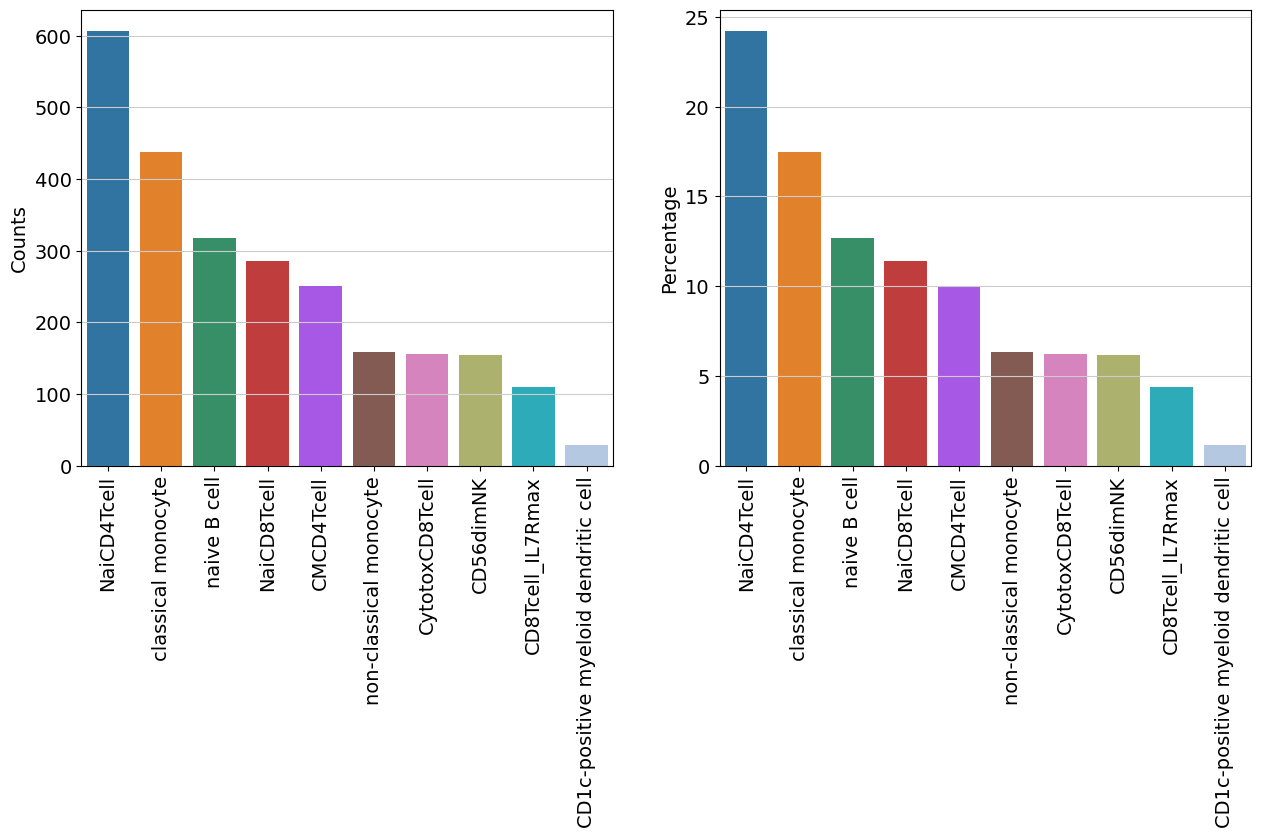

In [47]:
#generate a basic bar plot of the table above
fig = plt.figure(figsize=(15,6))

#visualize distribution before logarithmization
ax1 = fig.add_subplot(1, 2, 1)
ax1 = sns.barplot(data = data, x = data.index.tolist(), y = 'Counts' )
plt.xticks(rotation=90)

#visualize distribution after logarithmization
ax2 = fig.add_subplot(1, 2, 2)
ax2 = sns.barplot(data = data, x = data.index.tolist(), y = 'Percentage' )
plt.xticks(rotation=90)